In [1]:
%pylab inline
import camels_library as cl
import readgadget
from tqdm import tqdm

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
scales = []
poss = []
vels = []

snapshot='/project/rrg-lplevass/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/snap_000.hdf5'

header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='/project/rrg-lplevass/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3 #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]     #peculiar velocities in km/s

    # Reordering data for simple reshaping
#     pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
#     vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
#     pos = (pos / BoxSize * 32).reshape([256,256,256,3])[2::8,2::8,2::8,:].reshape([-1,3])
#     vel = (vel / 100 * (1./(1+redshift)) / BoxSize*32).reshape([256,256,256,3])[2::8,2::8,2::8,:].reshape([-1,3])
    
    downsampling_factor=10
    pos = jnp.array(pos)
    vel = jnp.array(vel / 100 * (1.0 / (1 + redshift)))

    key = jax.random.PRNGKey(0)
    permuted_indices = jax.random.permutation(key, len(pos))
    selected_indices = permuted_indices[: len(pos) // downsampling_factor]
    pos = jnp.take(pos, selected_indices, axis=0)
    vel = jnp.take(vel, selected_indices, axis=0)
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [01:32<00:00,  2.72s/it]


In [3]:
mesh_shape= [32, 32, 32]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.671 , sigma8=0.8)

In [4]:
# Run the simulation with Particle-Mesh scheme
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

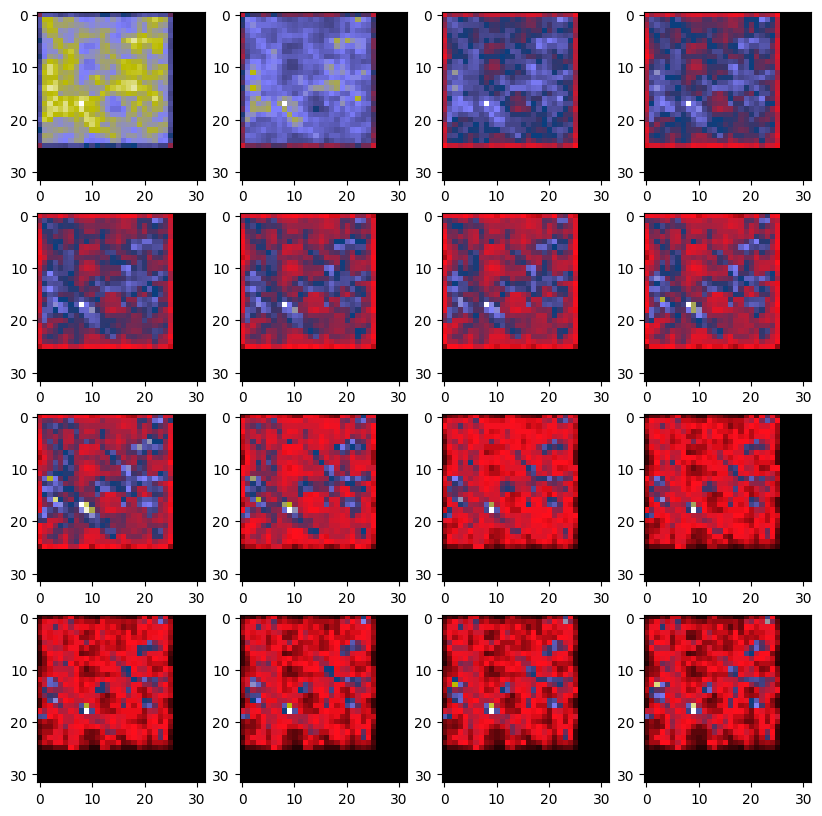

In [5]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

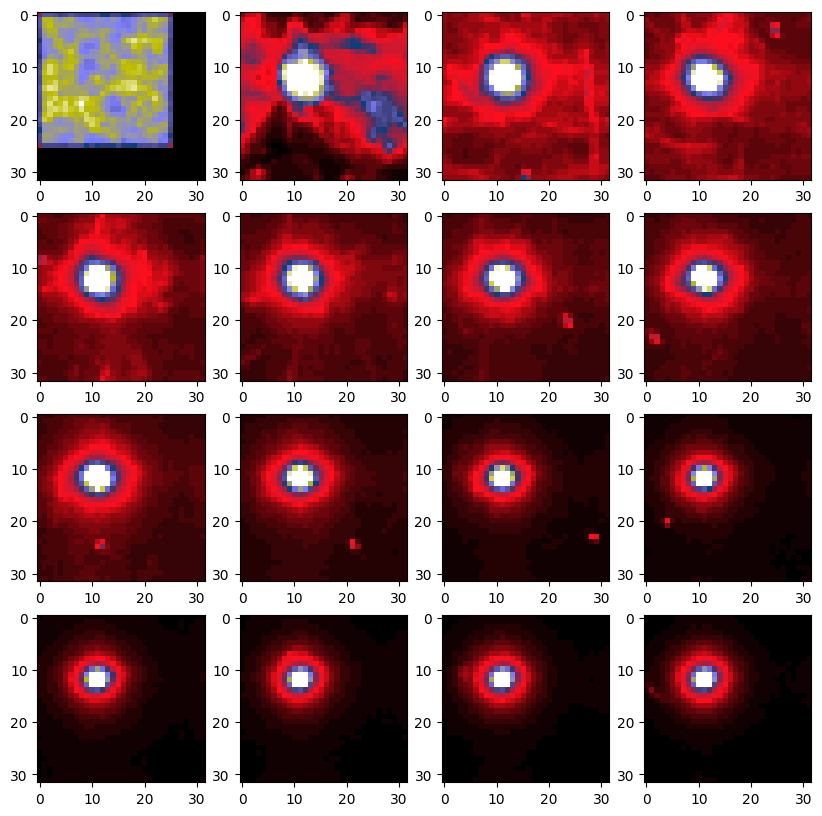

In [6]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)